# Addressing class imbalance

This notebook presents our evaluation of the impact of various "traditional" class imbalance dealing approaches on our task.

`**Disclaimer** this notebook is a summary of multiple experiments created to present the explorative process. We omited data loading and preprocessing, etc. For full, functioning notebooks see the 'examples' included.`

## Selecting ideal undersampling ratio

We will train and evaluate both ResNet and CNN on different ratios of data.


In [ ]:
df = pd.read_csv(f"{data_path}/train_set_1_100_CLASH2013_paper.tsv", sep="\t")

### CNN

In [ ]:
ratios = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for ratio in ratios:

  print("\n\n", "-" * 30)
  print("Ratio", ratio)
  print("-" * 30, "\n\n")

  # Prepare undersampled data

  NUM_POSITIVE = 15000
  df_train = pd.concat([
      df[(df['label'] == 0)].sample(n=NUM_POSITIVE*ratio, random_state=3167),
      df[df['label'] == 1].sample(frac=1., replace=False)
      ], axis=0).sample(frac=1.0)[['miRNA', 'gene', 'label']]
  df_train.reset_index(inplace=True)
  del df_train['index']

  tqdm.pandas(desc=f'Encoding ratio {ratio}')
  train_data = df_train[['miRNA', 'gene', 'label']].progress_apply(lambda row: encode_and_label(row, label_col="label"), axis=1, result_type='expand')

  # Prepare model
  cnn = make_architecture(name=f"cnn_1_{ratio}")
  cnn.compile(**{
          "optimizer": tf.keras.optimizers.Adam(name="adam", learning_rate=1e-3, beta_1=0.9, beta_2=0.999),
          "loss": tf.keras.losses.BinaryCrossentropy(),
          "metrics": [
                      # tf.keras.metrics.Precision(name="precision"),
                      # tf.keras.metrics.Recall(name="recall")
                      precision_,
                      recall_
                      ]
      })

  callbacks = [

      tf.keras.callbacks.EarlyStopping(
          monitor="val_loss", 
          min_delta=0.001, 
          patience=60, 
          verbose=1, 
          mode="min", 
          baseline=None, 
          restore_best_weights=True
      )

  ]

  _ = cnn.fit(
    x=np.array(list(train_data[0])), 
    y=np.array(list(train_data[1])), 

    shuffle=True,
    batch_size=128*8,
    validation_split=0.05,

    verbose=1,
    epochs=1000,
    callbacks=callbacks
    )
  
  cnn.save(f"{dir_path}/models_ratios/cnn_1_{ratio}.h5")
  

In [ ]:
models = [tf.keras.models.load_model(f"{dir_path}/models_ratios/cnn_1_{ratio}.h5", custom_objects={'precision_': precision_, 'recall_': recall_}) for ratio in [20,30,40,50,60,70,80,90,100]]
test_and_plot(models, test_data_1, test_data_10, test_data_100)

### ResNet

In [ ]:
ratios = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for ratio in ratios:

  print("\n\n", "-" * 30)
  print("Ratio", ratio)
  print("-" * 30, "\n\n")

  # Prepare undersampled data

  NUM_POSITIVE = 15000
  df_train = pd.concat([
      df[(df['label'] == 0)].sample(n=NUM_POSITIVE*ratio, random_state=3167),
      df[df['label'] == 1].sample(frac=1., replace=False)
      ], axis=0).sample(frac=1.0)[['miRNA', 'gene', 'label']]
  df_train.reset_index(inplace=True)
  del df_train['index']

  tqdm.pandas(desc=f'Encoding ratio {ratio}')
  train_data = df_train[['miRNA', 'gene', 'label']].progress_apply(lambda row: encode_and_label(row, label_col="label"), axis=1, result_type='expand')

  # Prepare model

  resnet = create_res_net(name=f"resnet_1_{ratio}")
  resnet.compile(**{
          "optimizer": tf.keras.optimizers.Adam(name="adam", learning_rate=1e-3, beta_1=0.9, beta_2=0.999),
          "loss": tf.keras.losses.BinaryCrossentropy(),
          "metrics": [
                      # tf.keras.metrics.Precision(name="precision"),
                      # tf.keras.metrics.Recall(name="recall")
                      precision_,
                      recall_
                      ]
      })

  callbacks = [

      tf.keras.callbacks.EarlyStopping(
          monitor="val_loss", 
          min_delta=0.001, 
          patience=60, 
          verbose=1, 
          mode="min", 
          baseline=None, 
          restore_best_weights=True
      )

  ]

  _ = resnet.fit(
    x=np.array(list(train_data[0])), 
    y=np.array(list(train_data[1])), 

    shuffle=True,
    batch_size=128*8,
    validation_split=0.05,

    verbose=1,
    epochs=1000,
    callbacks=callbacks
    )
  
  resnet.save(f"{dir_path}/models_ratios/resnet_1_{ratio}.h5")
  

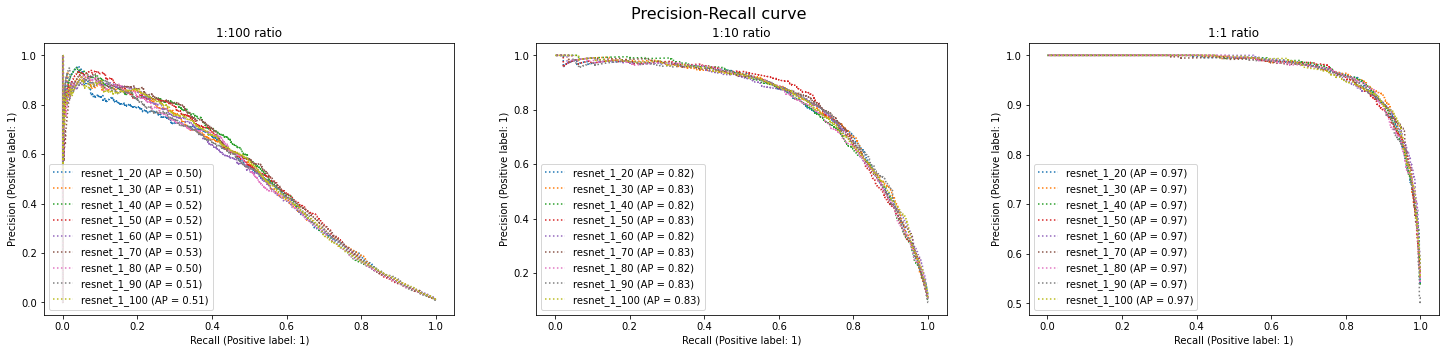

In [ ]:
models = [tf.keras.models.load_model(f"{dir_path}/models_ratios/resnet_1_{ratio}.h5", custom_objects={'precision_': precision_, 'recall_': recall_}) for ratio in [20,30,40,50,60,70,80,90,100]]
test_and_plot(models, test_data_1, test_data_10, test_data_100)


`Values copied from multiple notebooks ran on multiple computers`


In [ ]:
cnn_auc_100 = [0.42, 0.46, 0.45, 0.48, 0.49, 0.48, 0.50, 0.49, 0.50, 0.50, 0.49]
cnn_auc_10 = [0.80, 0.81, 0.80, 0.81, 0.81, 0.81, 0.82, 0.82, 0.82, 0.82, 0.82]
cnn_auc_1 = [0.97, 0.97, 0.96, 0.96, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97]
renset_auc_100 = [0.43, 0.45, 0.50, 0.51, 0.52, 0.52, 0.51, 0.53, 0.50, 0.51, 0.51]
renset_auc_10 = [0.80, 0.80, 0.82, 0.83, 0.82, 0.83, 0.82, 0.83, 0.82, 0.83, 0.83]
renset_auc_1 = [0.96, 0.96, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97]

In [ ]:
import matplotlib.pyplot as plt

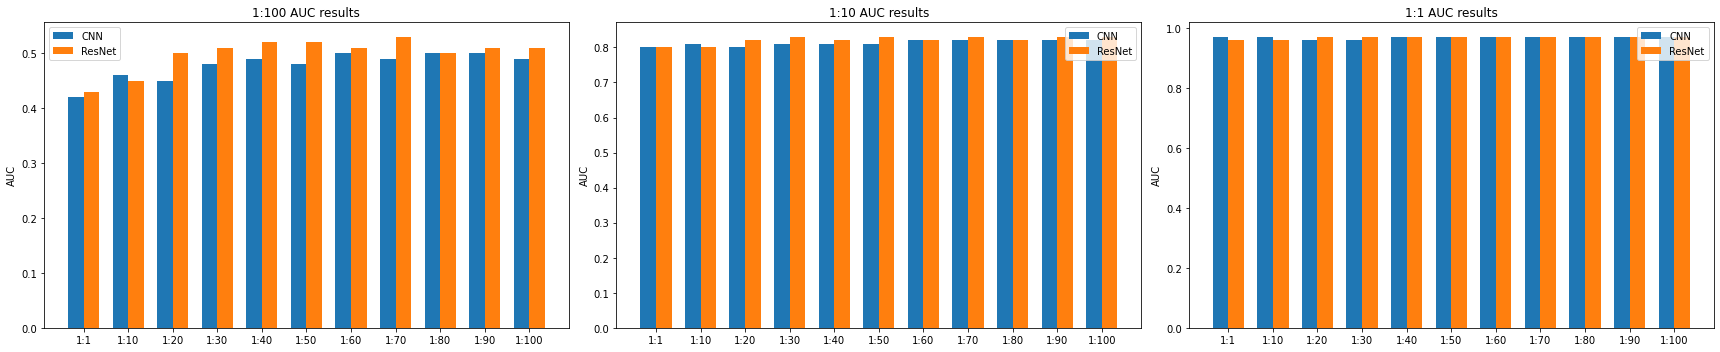

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = [f"1:{ratio}" for ratio in [1, 10, 20,30,40,50,60,70,80,90,100]]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(1, 3, figsize=(24,5))

rects1 = ax[0].bar(x - width/2, cnn_auc_100, width, label='CNN')
rects2 = ax[0].bar(x + width/2, renset_auc_100, width, label='ResNet')
ax[0].set_ylabel('AUC')
ax[0].set_title('1:100 AUC results')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
ax[0].legend()

rects1 = ax[1].bar(x - width/2, cnn_auc_10, width, label='CNN')
rects2 = ax[1].bar(x + width/2, renset_auc_10, width, label='ResNet')
ax[1].set_ylabel('AUC')
ax[1].set_title('1:10 AUC results')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[1].legend()

rects1 = ax[2].bar(x - width/2, cnn_auc_1, width, label='CNN')
rects2 = ax[2].bar(x + width/2, renset_auc_1, width, label='ResNet')
ax[2].set_ylabel('AUC')
ax[2].set_title('1:1 AUC results')
ax[2].set_xticks(x)
ax[2].set_xticklabels(labels)
ax[2].legend()

fig.tight_layout()

plt.show()

## EasyEnsemble

In [ ]:
positive_data = train_pool[train_pool[1] == 1]
negative_data = train_pool[train_pool[1] == 0]
num_positive = len(positive_data)

In [ ]:
models = []

In [ ]:
for model_num in range(10):

  print("\n\n")
  print("-" * 50)
  print("\t\tModel", model_num)
  print("-" * 50)
  print("\n\n")

  train_data = pd.concat([
      positive_data,
      negative_data.sample(n=num_positive)
  ]).sample(frac=1.0)
  train_data.reset_index(inplace=True)
  del train_data['index']

  # with strategy.scope():

  models.append(create_res_net(name=f"rs_{model_num}"))
  models[model_num].compile(**{
          "optimizer": tf.keras.optimizers.Adam(name="adam", learning_rate=1e-3, beta_1=0.9, beta_2=0.999),
          "loss": tf.keras.losses.BinaryCrossentropy(),
          "metrics": [precision_, recall_]
      })
  
  # Init callbacks
  callbacks = [

    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        min_delta=0.0001, 
        patience=10, 
        verbose=1, 
        mode="min", 
        baseline=None, 
        restore_best_weights=True
    )

  ]

  history = models[model_num].fit(
      x=np.array(list(train_data[0])), 
      y=np.array(list(train_data[1])), 

      shuffle=True,
      batch_size=64*8,
      validation_split=0.05,

      verbose=1,
      epochs=1000,
      callbacks=callbacks
      )

  models[model_num].save(f"{dir_path}/models/rs_{model_num}.h5")




--------------------------------------------------
		Model 0
--------------------------------------------------



Epoch 1/1000


2022-05-12 10:30:48.043809: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-05-12 10:30:49.553872: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-05-12 10:30:49.555278: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-05-12 10:30:49.555306: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-05-12 10:30:49.555805: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

58/58 [==============================] - 15s 142ms/step - loss: 0.6249 - precision_: 0.6495 - recall_: 0.6249 - val_loss: 1.1079 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 2/1000
58/58 [==============================] - 7s 123ms/step - loss: 0.5113 - precision_: 0.7626 - recall_: 0.7414 - val_loss: 1.5111 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 3/1000
58/58 [==============================] - 7s 123ms/step - loss: 0.4525 - precision_: 0.8166 - recall_: 0.7656 - val_loss: 1.6017 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 4/1000
58/58 [==============================] - 7s 123ms/step - loss: 0.4273 - precision_: 0.8288 - recall_: 0.7819 - val_loss: 2.3107 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 5/1000
58/58 [==============================] - 7s 124ms/step - loss: 0.4114 - precision_: 0.8424 - recall_: 0.7884 - val_loss: 2.3846 - val_precision_: 0.5000 - val_recall_: 0.0019
Epoch 6/1000
58/58 [====================

AP100 = 0.4331269592719119
AP10 = 0.7988110576892578
AP1 = 0.964496981376382
AP100 = 0.40318649034104015
AP10 = 0.7815847136897287
AP1 = 0.9603462298802682
AP100 = 0.4286760951265686
AP10 = 0.7960497979755633
AP1 = 0.9631873933845676
AP100 = 0.43187515022713363
AP10 = 0.7979804343821718
AP1 = 0.9635511304687511
AP100 = 0.420041981658186
AP10 = 0.7896229890746177
AP1 = 0.9614272510016292
AP100 = 0.42207207879865505
AP10 = 0.793585309432648
AP1 = 0.9637205517462426
AP100 = 0.4495933801721492
AP10 = 0.8011515075626122
AP1 = 0.965151260753561
AP100 = 0.43819156717114216
AP10 = 0.7994182940145244
AP1 = 0.9630343997743591
AP100 = 0.4046501528035376
AP10 = 0.7894071771245904
AP1 = 0.9612854410535361
AP100 = 0.4243359129035642
AP10 = 0.788750412651759
AP1 = 0.9592317620517006


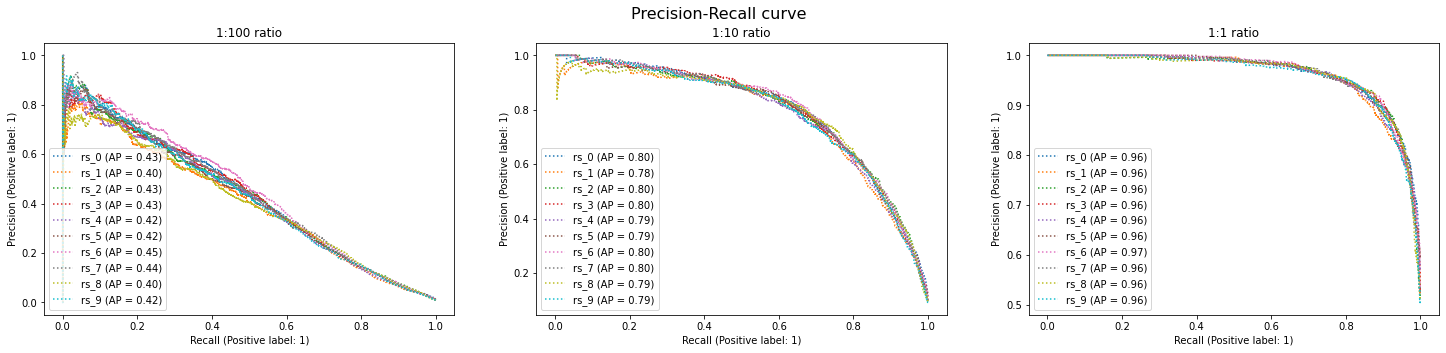

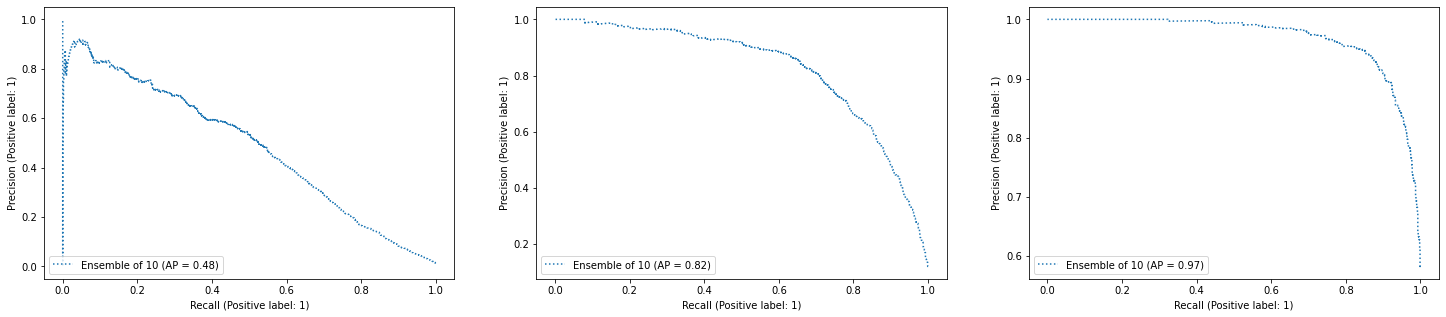

In [ ]:
test_and_plot(models, test_data_1, test_data_10, test_data_100, combine_method="mean")

AP100 = 0.4312677032048724
AP10 = 0.7943323763250847
AP1 = 0.96113084691473
AP100 = 0.3987553269142382
AP10 = 0.7844136346643888
AP1 = 0.9581553818260546
AP100 = 0.41719577881256675
AP10 = 0.7969995462184022
AP1 = 0.9612597882062714
AP100 = 0.4302361495569125
AP10 = 0.7909732350085957
AP1 = 0.9598157970952957
AP100 = 0.4105049943183501
AP10 = 0.7833996256275381
AP1 = 0.9597522514493703
AP100 = 0.41269727801234835
AP10 = 0.7853050926521878
AP1 = 0.9600741537841834
AP100 = 0.43130667001462003
AP10 = 0.7973355053431757
AP1 = 0.9623202590589328
AP100 = 0.4284389214824412
AP10 = 0.7932881899227303
AP1 = 0.9590947199306109
AP100 = 0.38378558376812894
AP10 = 0.7744712545675567
AP1 = 0.9547605690435246
AP100 = 0.39984074589362406
AP10 = 0.7781087641355132
AP1 = 0.9574594883747156


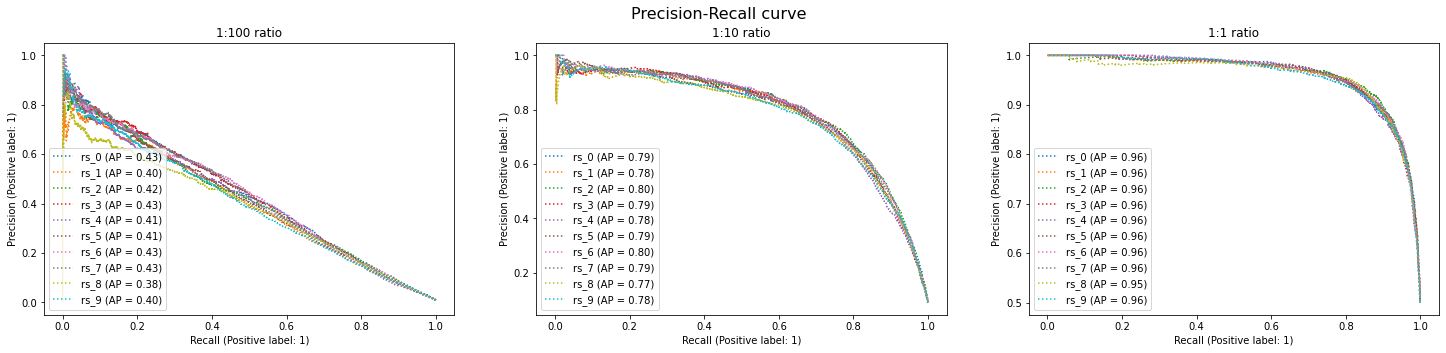

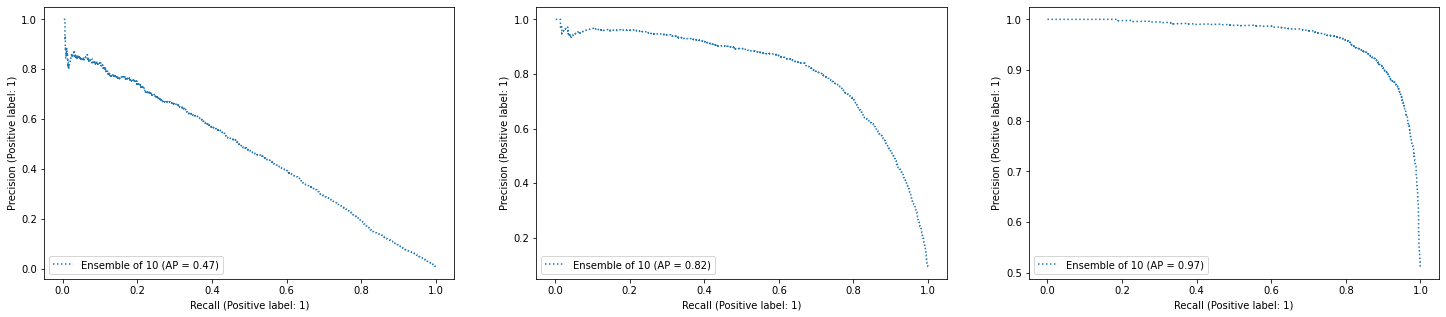

In [ ]:
test_and_plot(models, test_1, test_10, test_100, combine_method="mean")

In [ ]:
save_predictions(models, test_data_1, test_data_10, test_data_100, csv_name="easy_ensemble_preds")

rs_0
rs_1
rs_2
rs_3
rs_4
rs_5
rs_6
rs_7
rs_8
rs_9


## BalanceCascade

In [ ]:
positive_data = train_pool[train_pool[1] == 1]
negative_data = train_pool[train_pool[1] == 0]
num_positive = len(positive_data)

In [ ]:
models_bc = []

In [ ]:
for model_num in range(10):

  print("\n\n")
  print("-" * 50)
  print("\t\tModel", model_num)
  print("-" * 50)
  print("\n\n")

  if len(negative_data) < num_positive:
    break

  train_data = pd.concat([
      positive_data,
      negative_data.sample(n=num_positive)
  ]).sample(frac=1.0)
  train_data.reset_index(inplace=True)
  del train_data['index']

  # with strategy.scope():

  models_bc.append(create_res_net(name=f"rs_{model_num}"))
  models_bc[model_num].compile(**{
          "optimizer": tf.keras.optimizers.Adam(name="adam", learning_rate=1e-3, beta_1=0.9, beta_2=0.999),
          "loss": tf.keras.losses.BinaryCrossentropy(),
          "metrics": [precision_, recall_]
      })
  
  # Init callbacks
  callbacks = [

    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        min_delta=0.0001, 
        patience=10, 
        verbose=1, 
        mode="min", 
        baseline=None, 
        restore_best_weights=True
    )

  ]

  history = models_bc[model_num].fit(
      x=np.array(list(train_data[0])), 
      y=np.array(list(train_data[1])), 

      shuffle=True,
      batch_size=64*8,
      validation_split=0.05,

      verbose=1,
      epochs=1000,
      callbacks=callbacks
      )

  models_bc[model_num].save(f"{dir_path}/models/rs_bc_{model_num}.h5")

  # Remove all correctly classified samples from negative_data
  preds = models_bc[model_num].predict(np.array(list(negative_data[0])), batch_size=2048, verbose=1)
  negative_data = negative_data[preds >= 0.5]





--------------------------------------------------
		Model 0
--------------------------------------------------



Epoch 1/1000
58/58 [==============================] - 11s 138ms/step - loss: 0.6457 - precision_: 0.6274 - recall_: 0.6067 - val_loss: 1.0400 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 2/1000
58/58 [==============================] - 7s 123ms/step - loss: 0.5356 - precision_: 0.7394 - recall_: 0.7318 - val_loss: 1.6517 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 3/1000
58/58 [==============================] - 7s 124ms/step - loss: 0.4661 - precision_: 0.8060 - recall_: 0.7593 - val_loss: 2.4713 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 4/1000
58/58 [==============================] - 7s 124ms/step - loss: 0.4362 - precision_: 0.8240 - recall_: 0.7756 - val_loss: 3.2540 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 5/1000
58/58 [==============================] - 7s 124ms/step - loss: 0.4146 - precision_: 

2022-05-12 13:54:31.372847: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 6156800000 exceeds 10% of free system memory.
2022-05-12 13:54:36.202303: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 6156800000 exceeds 10% of free system memory.


752/752 [==============================] - 92s 121ms/step



--------------------------------------------------
		Model 1
--------------------------------------------------



Epoch 1/1000
58/58 [==============================] - 11s 134ms/step - loss: 0.6991 - precision_: 0.5408 - recall_: 0.5094 - val_loss: 0.8525 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 2/1000
58/58 [==============================] - 7s 124ms/step - loss: 0.6790 - precision_: 0.5832 - recall_: 0.5534 - val_loss: 0.8528 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 3/1000
58/58 [==============================] - 7s 125ms/step - loss: 0.6569 - precision_: 0.6199 - recall_: 0.6049 - val_loss: 0.7552 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 4/1000
58/58 [==============================] - 7s 124ms/step - loss: 0.6332 - precision_: 0.6570 - recall_: 0.6151 - val_loss: 0.7992 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 5/1000
58/58 [===================

In [ ]:
models_bc = [tf.keras.models.load_model(f"{dir_path}/models/rs_bc_{model_num}.h5", custom_objects={"precision_": precision_, "recall_": recall_}) for model_num in range(4)]

2022-05-12 14:32:16.426998: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-05-12 14:32:17.525847: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-05-12 14:32:17.527901: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-05-12 14:32:17.527928: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-05-12 14:32:17.528118: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

AP100 = 0.4031254978871227
AP10 = 0.7881743590144292
AP1 = 0.959874655492075
AP100 = 0.25938114672921503
AP10 = 0.5190347524155762
AP1 = 0.8379432031160348
AP100 = 0.016824744408705218
AP10 = 0.14643152010952581
AP1 = 0.6049268300417402
AP100 = 0.007443845937381032
AP10 = 0.06970753182702447
AP1 = 0.42428243777931673


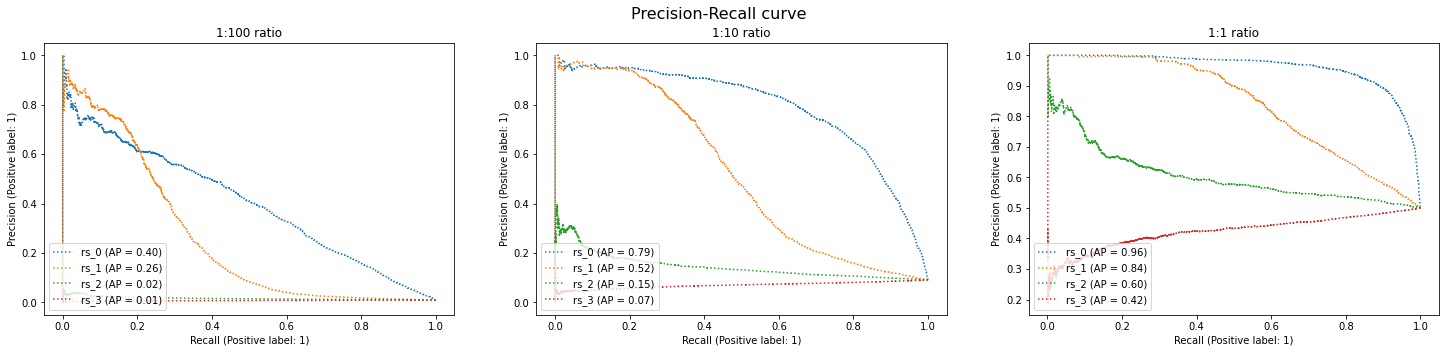

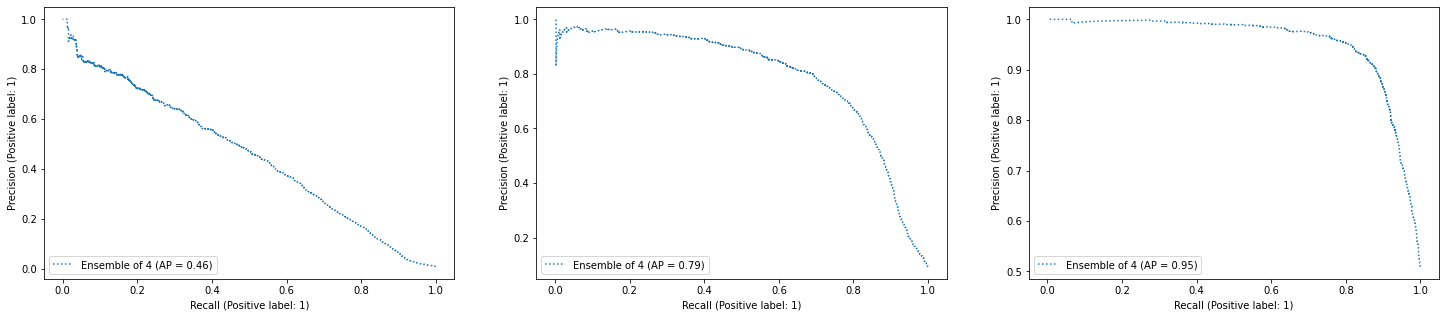

In [ ]:
test_and_plot(models_bc, test_1, test_10, test_100, combine_method="mean")

In [ ]:
save_predictions(models_bc, test_data_1, test_data_10, test_data_100, csv_name="balance_cascade_preds")

rs_0
rs_1
rs_2
rs_3


## Two-phase training

In [ ]:
positive_data = train_pool[train_pool[1] == 1]
negative_data = train_pool[train_pool[1] == 0]
num_positive = len(positive_data)

In [ ]:
train_data = pd.concat([
    positive_data,
    negative_data.sample(n=num_positive)
]).sample(frac=1.0)
train_data.reset_index(inplace=True)
del train_data['index']

# with strategy.scope():

model = create_res_net(name=f"rs")
model.compile(**{
        "optimizer": tf.keras.optimizers.Adam(name="adam", learning_rate=1e-3, beta_1=0.9, beta_2=0.999),
        "loss": tf.keras.losses.BinaryCrossentropy(),
        "metrics": [precision_, recall_]
    })

# Init callbacks
callbacks = [

  tf.keras.callbacks.EarlyStopping(
      monitor="val_loss", 
      min_delta=0.0001, 
      patience=10, 
      verbose=1, 
      mode="min", 
      baseline=None, 
      restore_best_weights=True
  )

]

history = model.fit(
    x=np.array(list(train_data[0])), 
    y=np.array(list(train_data[1])), 

    shuffle=True,
    batch_size=64*8,
    validation_split=0.05,

    verbose=1,
    epochs=1000,
    callbacks=callbacks
    )

# Freeze layers and retrain the top layer
for l in model.layers[:-1]:
  l.trainable = False

model.summary()

# Recompile with a small LR!
model.compile(**{
        "optimizer": tf.keras.optimizers.Adam(name="adam", learning_rate=1e-5, beta_1=0.9, beta_2=0.999),
        "loss": tf.keras.losses.BinaryCrossentropy(),
        "metrics": [precision_, recall_]
    })

# Init callbacks
callbacks = [

  tf.keras.callbacks.EarlyStopping(
      monitor="val_loss", 
      min_delta=0.0001, 
      patience=10, 
      verbose=1, 
      mode="min", 
      baseline=None, 
      restore_best_weights=True
  )

]

# Use a more realistic ratio!
train_data = pd.concat([
    positive_data,
    negative_data.sample(n=num_positive * 50)
]).sample(frac=1.0)
train_data.reset_index(inplace=True)
del train_data['index']

print(f"Now using {len(train_data)} samples.")

history = model.fit(
    x=np.array(list(train_data[0])), 
    y=np.array(list(train_data[1])), 

    shuffle=True,
    batch_size=128*8,
    validation_split=0.05,

    verbose=1,
    epochs=1000,
    callbacks=callbacks
    )



model.save(f"{dir_path}/models/rs_tp.h5")


Epoch 1/1000


2022-05-12 14:53:56.493148: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


58/58 [==============================] - 12s 141ms/step - loss: 0.6232 - precision_: 0.6613 - recall_: 0.6298 - val_loss: 1.2064 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 2/1000
58/58 [==============================] - 7s 122ms/step - loss: 0.4983 - precision_: 0.7719 - recall_: 0.7483 - val_loss: 1.3976 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 3/1000
58/58 [==============================] - 7s 122ms/step - loss: 0.4473 - precision_: 0.8213 - recall_: 0.7657 - val_loss: 2.5917 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 4/1000
58/58 [==============================] - 7s 122ms/step - loss: 0.4277 - precision_: 0.8334 - recall_: 0.7786 - val_loss: 2.4061 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 5/1000
58/58 [==============================] - 7s 122ms/step - loss: 0.4114 - precision_: 0.8417 - recall_: 0.7867 - val_loss: 2.8001 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 6/1000
58/58 [============

2022-05-12 14:57:45.347238: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2982968000 exceeds 10% of free system memory.
2022-05-12 14:57:46.707848: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2982968000 exceeds 10% of free system memory.


Epoch 1/1000
729/729 [==============================] - 67s 90ms/step - loss: 0.3784 - precision_: 0.1076 - recall_: 0.9191 - val_loss: 0.2667 - val_precision_: 0.1459 - val_recall_: 0.9085
Epoch 2/1000
729/729 [==============================] - 65s 89ms/step - loss: 0.3518 - precision_: 0.1136 - recall_: 0.9135 - val_loss: 0.2499 - val_precision_: 0.1526 - val_recall_: 0.9033
Epoch 3/1000
729/729 [==============================] - 65s 90ms/step - loss: 0.3269 - precision_: 0.1207 - recall_: 0.9095 - val_loss: 0.2348 - val_precision_: 0.1597 - val_recall_: 0.8938
Epoch 4/1000
729/729 [==============================] - 65s 89ms/step - loss: 0.3044 - precision_: 0.1288 - recall_: 0.8973 - val_loss: 0.2211 - val_precision_: 0.1685 - val_recall_: 0.8856
Epoch 5/1000
729/729 [==============================] - 65s 90ms/step - loss: 0.2847 - precision_: 0.1383 - recall_: 0.8869 - val_loss: 0.2088 - val_precision_: 0.1755 - val_recall_: 0.8643
Epoch 6/1000
729/729 [============================

KeyboardInterrupt: ignored

AP100 = 0.2666207408934543
AP10 = 0.683643853342097
AP1 = 0.9265429736507766


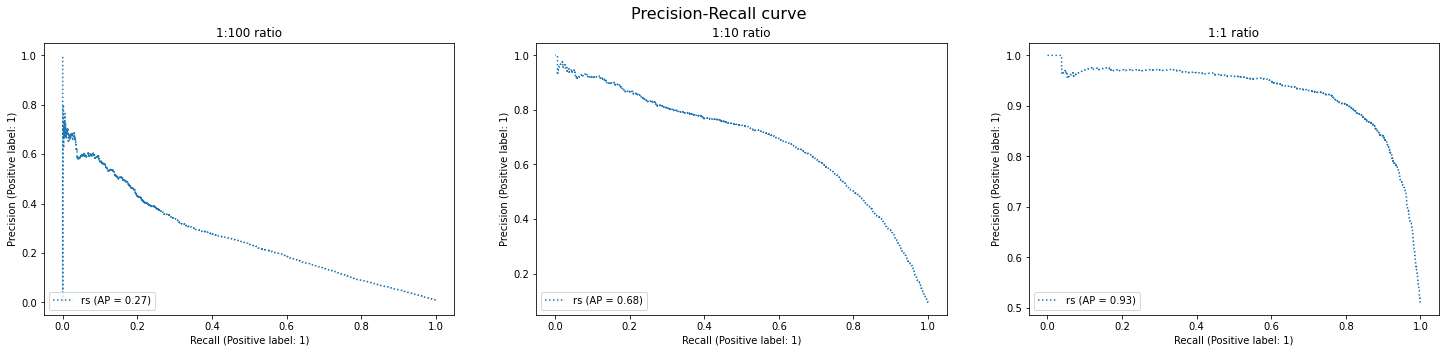

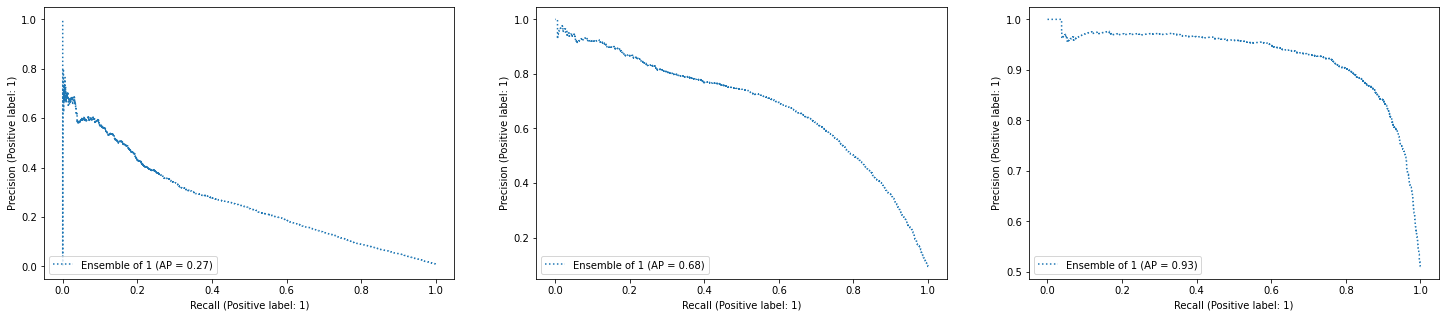

In [ ]:
test_and_plot([model], test_1, test_10, test_100, combine_method="mean")

In [ ]:
save_predictions([model], test_data_1, test_data_10, test_data_100, csv_name="two_phase_preds")

rs


## RandomOverSampler

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
positive_data = train_pool[train_pool[1] == 1]
negative_data = train_pool[train_pool[1] == 0]
num_positive = len(positive_data)

In [ ]:
train_data = pd.concat([
    positive_data,
    negative_data.sample(n=num_positive * 10)
]).sample(frac=1.0)
train_data.reset_index(inplace=True)
del train_data['index']

In [ ]:
sampler = RandomOverSampler(sampling_strategy='auto', random_state=None)

In [ ]:
x = np.array(list(train_data[0]))
x = x.reshape(*x.shape[:-3], -1)
x.shape

(169312, 1000)

In [ ]:
X_resampled, y_resampled = sampler.fit_resample(x, np.array(list(train_data[1])))

In [ ]:
X_resampled.shape[0]

307840

In [ ]:
# Reshape samples back

X_resampled
X_resampled = X_resampled.reshape((X_resampled.shape[0], 50, 20, 1))
X_resampled.shape

(307840, 50, 20, 1)

In [ ]:
# Shuffle training data

n_elem = X_resampled.shape[0]
indeces = np.random.choice(n_elem, size=n_elem, replace=False)
X_resampled = X_resampled[indeces]
y_resampled = y_resampled[indeces]

In [ ]:
print("number of positive : negative samples =>", np.bincount(y_resampled))

number of positive : negative samples => [153920 153920]


In [ ]:

# with strategy.scope():

model = create_res_net(name=f"rs")
model.compile(**{
        "optimizer": tf.keras.optimizers.Adam(name="adam", learning_rate=1e-3, beta_1=0.9, beta_2=0.999),
        "loss": tf.keras.losses.BinaryCrossentropy(),
        "metrics": [precision_, recall_]
    })

# Init callbacks
callbacks = [

  tf.keras.callbacks.EarlyStopping(
      monitor="val_loss", 
      min_delta=0.0001, 
      patience=10, 
      verbose=1, 
      mode="min", 
      baseline=None, 
      restore_best_weights=True
  )

]

history = model.fit(
    x=X_resampled, 
    y=y_resampled, 

    shuffle=True,
    batch_size=64*8,
    validation_split=0.05,

    verbose=1,
    epochs=1000,
    callbacks=callbacks
    )

model.save(f"{dir_path}/models/rs_random_oversampling.h5")


Epoch 1/1000
572/572 [==============================] - 73s 122ms/step - loss: 0.4364 - precision_: 0.8103 - recall_: 0.7747 - val_loss: 0.3361 - val_precision_: 0.9282 - val_recall_: 0.7980
Epoch 2/1000
572/572 [==============================] - 69s 121ms/step - loss: 0.3007 - precision_: 0.8809 - recall_: 0.8713 - val_loss: 0.2664 - val_precision_: 0.8783 - val_recall_: 0.9343
Epoch 3/1000
572/572 [==============================] - 69s 120ms/step - loss: 0.2584 - precision_: 0.8960 - recall_: 0.8971 - val_loss: 0.2386 - val_precision_: 0.9338 - val_recall_: 0.8803
Epoch 4/1000
572/572 [==============================] - 69s 121ms/step - loss: 0.2411 - precision_: 0.9009 - recall_: 0.9056 - val_loss: 0.2241 - val_precision_: 0.9287 - val_recall_: 0.8932
Epoch 5/1000
572/572 [==============================] - 69s 121ms/step - loss: 0.2314 - precision_: 0.9031 - recall_: 0.9109 - val_loss: 0.2076 - val_precision_: 0.9192 - val_recall_: 0.9164
Epoch 6/1000
572/572 [=======================

AP100 = 0.41429653386651494
AP10 = 0.7874604687702218
AP1 = 0.9607468303175704


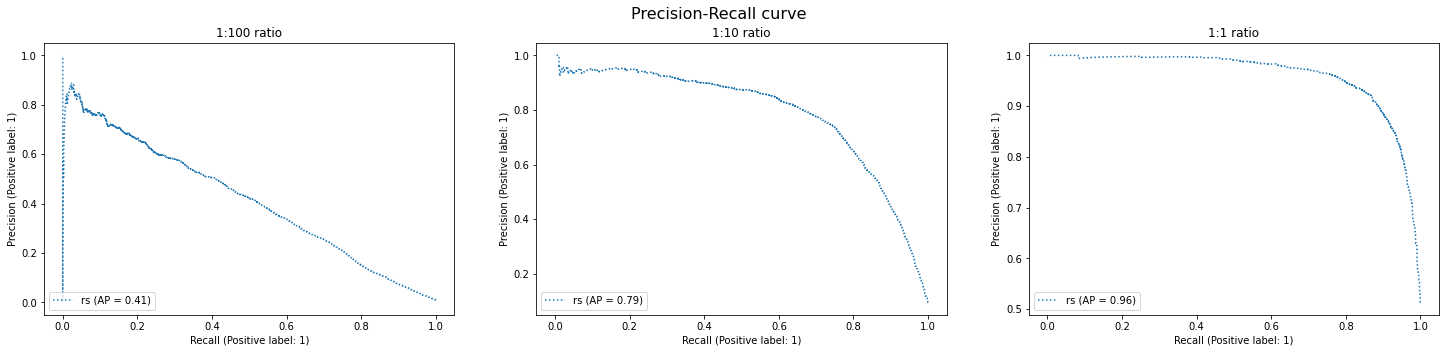

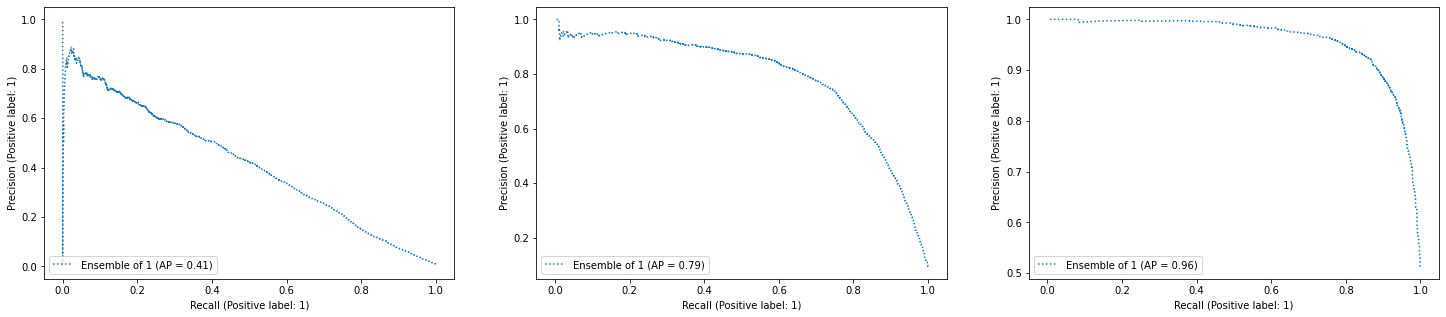

In [ ]:
test_and_plot([model], test_1, test_10, test_100, combine_method="mean")

In [ ]:
save_predictions([model], test_data_1, test_data_10, test_data_100, csv_name="random_oversampling_preds")

rs


## SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
positive_data = train_pool[train_pool[1] == 1]
negative_data = train_pool[train_pool[1] == 0]
num_positive = len(positive_data)

In [ ]:
train_data = pd.concat([
    positive_data,
    negative_data.sample(n=num_positive * 10)
]).sample(frac=1.0)
train_data.reset_index(inplace=True)
del train_data['index']

In [ ]:
sampler = SMOTE(sampling_strategy='auto', random_state=None, k_neighbors=5, n_jobs=None)

In [ ]:
x = np.array(list(train_data[0]))
x = x.reshape(*x.shape[:-3], -1)
x.shape

(169312, 1000)

In [ ]:
X_resampled, y_resampled = sampler.fit_resample(x, np.array(list(train_data[1])))

In [ ]:
X_resampled.shape[0]

307840

In [ ]:
# Reshape samples back

X_resampled
X_resampled = X_resampled.reshape((X_resampled.shape[0], 50, 20, 1))
X_resampled.shape

(307840, 50, 20, 1)

In [ ]:
# Shuffle training data

n_elem = X_resampled.shape[0]
indeces = np.random.choice(n_elem, size=n_elem, replace=False)
X_resampled = X_resampled[indeces]
y_resampled = y_resampled[indeces]

In [ ]:
print("number of positive : negative samples =>", np.bincount(y_resampled))

number of positive : negative samples => [153920 153920]


In [ ]:

# with strategy.scope():

model = create_res_net(name=f"rs")
model.compile(**{
        "optimizer": tf.keras.optimizers.Adam(name="adam", learning_rate=1e-3, beta_1=0.9, beta_2=0.999),
        "loss": tf.keras.losses.BinaryCrossentropy(),
        "metrics": [precision_, recall_]
    })

# Init callbacks
callbacks = [

  tf.keras.callbacks.EarlyStopping(
      monitor="val_loss", 
      min_delta=0.0001, 
      patience=10, 
      verbose=1, 
      mode="min", 
      baseline=None, 
      restore_best_weights=True
  )

]

history = model.fit(
    x=X_resampled, 
    y=y_resampled, 

    shuffle=True,
    batch_size=64*8,
    validation_split=0.05,

    verbose=1,
    epochs=1000,
    callbacks=callbacks
    )

model.save(f"{dir_path}/models/rs_smote.h5")


Epoch 1/1000
572/572 [==============================] - 73s 123ms/step - loss: 0.1928 - precision_: 0.9666 - recall_: 0.8848 - val_loss: 5.3029 - val_precision_: 0.5046 - val_recall_: 1.0000
Epoch 2/1000
572/572 [==============================] - 70s 123ms/step - loss: 0.1419 - precision_: 0.9707 - recall_: 0.9215 - val_loss: 5.4293 - val_precision_: 0.5046 - val_recall_: 1.0000
Epoch 3/1000
572/572 [==============================] - 69s 120ms/step - loss: 0.1199 - precision_: 0.9736 - recall_: 0.9362 - val_loss: 5.3908 - val_precision_: 0.5049 - val_recall_: 1.0000
Epoch 4/1000
572/572 [==============================] - 69s 120ms/step - loss: 0.1017 - precision_: 0.9771 - recall_: 0.9473 - val_loss: 2.0025 - val_precision_: 0.5661 - val_recall_: 0.9987
Epoch 5/1000
572/572 [==============================] - 69s 120ms/step - loss: 0.0932 - precision_: 0.9778 - recall_: 0.9530 - val_loss: 0.0948 - val_precision_: 0.9632 - val_recall_: 0.9690
Epoch 6/1000
572/572 [=======================

AP100 = 0.45408213949878956
AP10 = 0.7987099707931706
AP1 = 0.9618466395542281


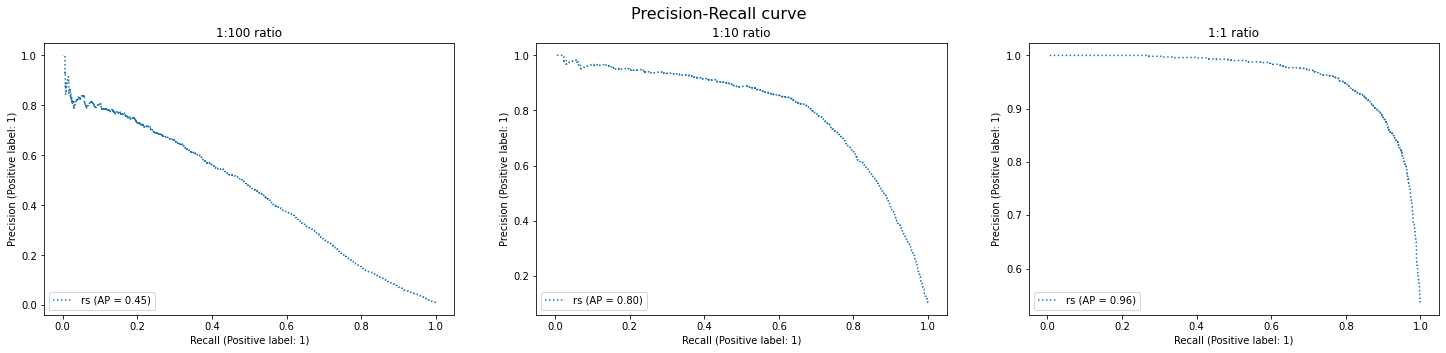

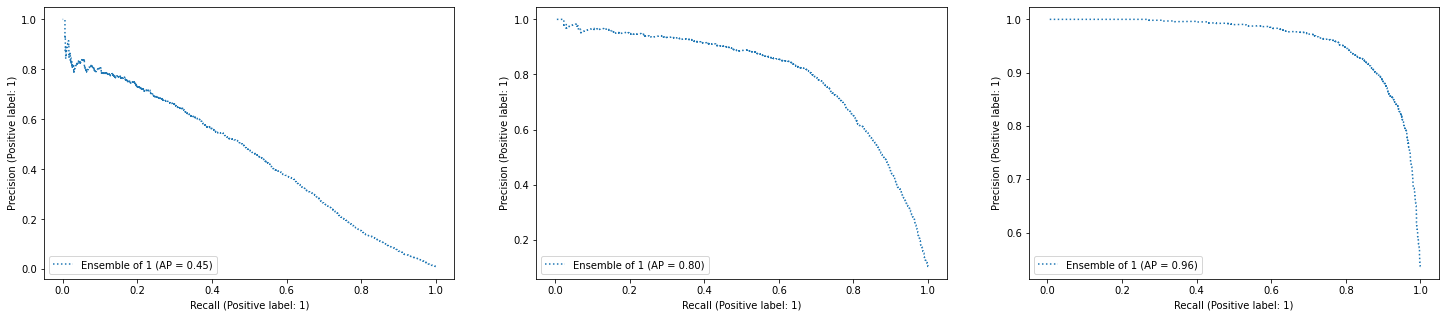

In [ ]:
test_and_plot([model], test_1, test_10, test_100, combine_method="mean")

In [ ]:
save_predictions([model], test_data_1, test_data_10, test_data_100, csv_name="smote_preds")

rs
